# Network Wrapping

Following the outputs of the Network-Architecture-Design notebook, this notebook wraps the resulted CNN in order to produce Training-loss and Regions-Of-Interest (ROI) for detection.

Note that the ROI are the "final station" in our case, and not initial "selective search" as in the original Faster-RCNN.

This notebook is heavily based on [this](https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439) detailed tutorial of Faster-RCNN implementation.

Most of the relevant code is implemented in DetectorNetwork.py and only called here.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import DetectorNetwork as dn

In [3]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter, OrderedDict
import cv2
from PIL import Image

In [4]:
import torch as t
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision as tv

In [5]:
mpl.rcParams.update({'font.size': 14})
CMAP = plt.get_cmap('rainbow')

### Initialization

In [6]:
labels, locations, anchors = dn.get_training_labels()

(291600, 10) (291600, 4, 10) (291600, 4)


In [7]:
files, images, W, H = dn.get_training_images()
image = images[0]

Image shape: 1920 1080


In [8]:
conv = dn.get_resnet_conv_model()
dn.set_grad(conv, 0)

Params to set grad for: 48


In [9]:
features, X, map_h, map_w, feature_size = dn.get_features(image, conv)
print('Total anchors:', map_h * map_w * (3*3))

Pre shape,mean,std torch.Size([1, 3, 1080, 1920]) tensor(133.2651) tensor(51.7660)
Post shape,mean,std torch.Size([1, 3, 1080, 1920]) tensor(0.4490) tensor(0.2284)
Feature-map shape: torch.Size([1, 128, 135, 240])
Feature size: 8
Total anchors: 291600


In [10]:
head = dn.RPN(features=features)
head.initialize_params()
dn.set_grad(head, 0)

Network channels: 128 -> 256 -> 45


In [11]:
scores, locs = head(features, verbose=True)

For a single image - shapes of features, mid-layer, locations and scores:
torch.Size([1, 128, 135, 240])
torch.Size([1, 256, 135, 240])
torch.Size([1, 36, 135, 240])
torch.Size([1, 9, 135, 240])


_______________

## RPN wrapper

Wrap-up the Region-Proposal-Network to transform its outputs into actual proposals of objects detections and locations.

In [14]:
scores = dn.labs_wrap(scores)
locs = dn.locs_wrap(locs)

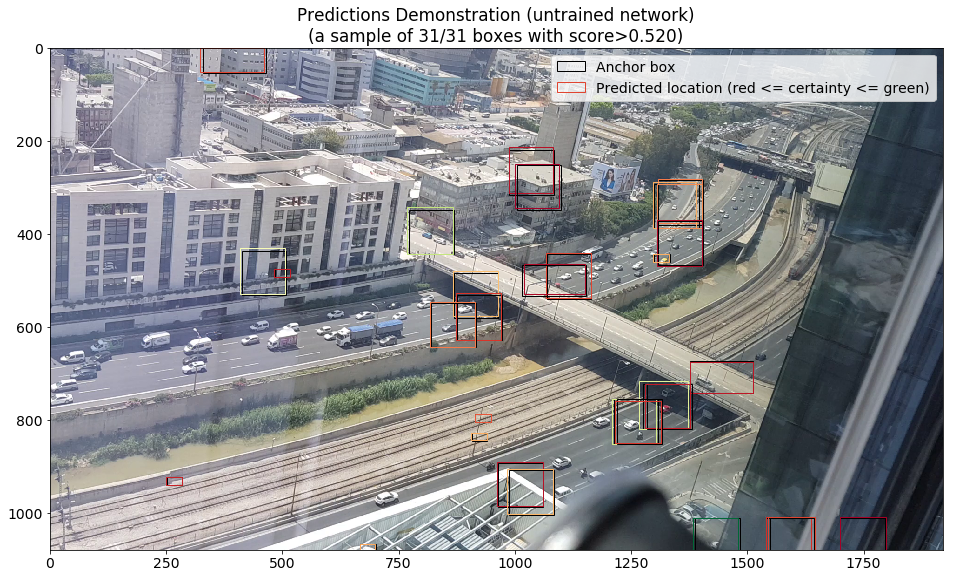

In [15]:
loc_fac = dn.LocationFactory(anchors, H, W)
dn.show_preds(scores, locs, loc_fac, anchors, image, thresh=0.52, fsize=(16,10),
              title='Predictions Demonstration (untrained network)')

_______________

## Loss function

Use network output to calculate loss for training.

In [16]:
rpn_loss = dn.RPN_loss(scores, locs, labels[:,0], locations[:,:,0], verbose=True)

All / backgrounds / objects: torch.Size([291600]) tensor(266852) tensor(118)
Losses (labels, locations): tensor(0.6908, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.7072, grad_fn=<MulBackward0>)


_______________

## ROI proposals

Use network output to produce proposals for Regions Of Interest.
This includes several steps that are not used for training loss, e.g. eliminating low-confidence regions and highly-overlapping regions.

In [19]:
roi, roi_scores = dn.regions_of_interest(scores, locs, nms_thresh=0.5, loc_fac=loc_fac, verbose=True)

Original size:	 (291600, 4) (291600,)
Invalid size filter:	 (291600, 4) (291600,)
Lowest scores filter:	 (12000, 4) (12000,)
NMS filter:	 (2000, 4) (2000,)


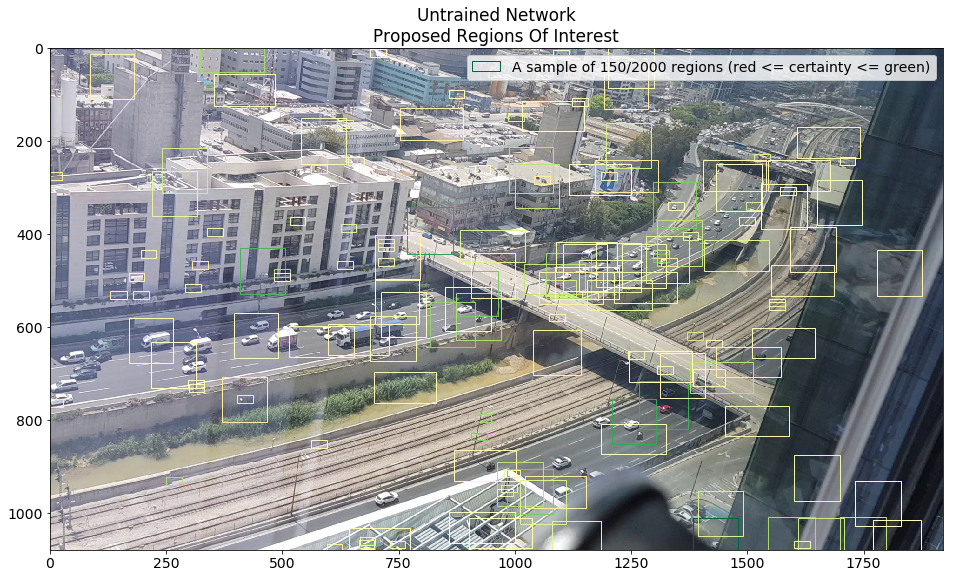

In [21]:
dn.show_roi(roi_scores, roi, loc_fac, image, fsize=(16,10),
            title='Untrained Network')